## Import Libraries

In [22]:
import kagglehub
import cv2
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage import measure
from scipy import stats
from skimage.feature import graycomatrix, graycoprops
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [23]:
from pathlib import Path

print("=== KONFIGURASI INPUT USER ===")
dataset_ref = input("Masukkan dataset Kaggle (tekan Enter untuk default raddar/tuberculosis-chest-xrays-shenzhen): ").strip() or "raddar/tuberculosis-chest-xrays-shenzhen"
limit_extract_raw = input("Batasi jumlah gambar saat ekstraksi fitur? (Enter untuk semua): ").strip()
limit_extract = int(limit_extract_raw) if limit_extract_raw else None
user_image_path_raw = input("Masukkan path gambar tunggal untuk dianalisis (Enter untuk skip): ").strip()
user_image_path = Path(user_image_path_raw).expanduser() if user_image_path_raw else None

CONFIG = {
    "dataset_ref": dataset_ref,
    "limit_extract": limit_extract,
    "user_image_path": user_image_path,
}

print("\nRingkasan konfigurasi:")
for key, value in CONFIG.items():
    print(f"  - {key}: {value if value else 'default/none'}")

=== KONFIGURASI INPUT USER ===

Ringkasan konfigurasi:
  - dataset_ref: raddar/tuberculosis-chest-xrays-shenzhen
  - limit_extract: default/none
  - user_image_path: D:\Vscode\MicrosoftVSCode\PCD\Project\TBC_Testing.jpg

Ringkasan konfigurasi:
  - dataset_ref: raddar/tuberculosis-chest-xrays-shenzhen
  - limit_extract: default/none
  - user_image_path: D:\Vscode\MicrosoftVSCode\PCD\Project\TBC_Testing.jpg


## Import dataset

In [24]:
%pip install kagglehub

# Download dataset langsung dari kaggle berdasarkan input user
dataset_ref = CONFIG.get("dataset_ref", "raddar/tuberculosis-chest-xrays-shenzhen")
print(f"Mengunduh dataset: {dataset_ref}")
path = kagglehub.dataset_download(dataset_ref)
print("Path to dataset files:", path)

Note: you may need to restart the kernel to use updated packages.
Mengunduh dataset: raddar/tuberculosis-chest-xrays-shenzhen
Path to dataset files: C:\Users\LENOVO\.cache\kagglehub\datasets\raddar\tuberculosis-chest-xrays-shenzhen\versions\1
Path to dataset files: C:\Users\LENOVO\.cache\kagglehub\datasets\raddar\tuberculosis-chest-xrays-shenzhen\versions\1


Menggunakan folder dataset: C:\Users\LENOVO\.cache\kagglehub\datasets\raddar\tuberculosis-chest-xrays-shenzhen\versions\1
Banyak gambar pada dataset :  662

Menganalisis filename untuk menentukan label...
  Ditemukan 326 gambar normal
  Ditemukan 336 gambar TB

   Sampel Data

   Sampel Data


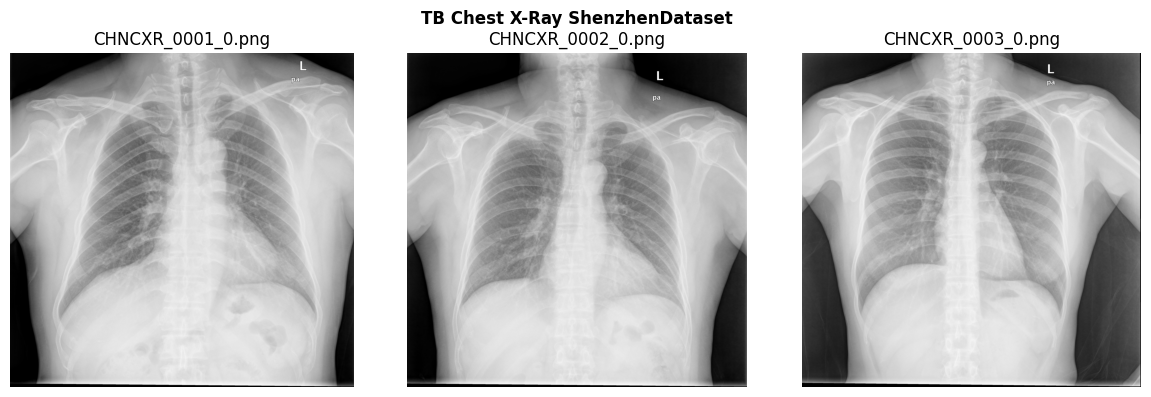

In [25]:
from pathlib import Path
from typing_extensions import dataclass_transform

# Pastikan variabel `path` dari proses unduh kagglehub sudah ada
if 'path' not in locals():
    raise RuntimeError("Variabel 'path' belum tersedia. Jalankan sel download kagglehub terlebih dahulu.")

# Gunakan folder hasil unduhan kagglehub secara langsung
img_path = Path(path)
if not img_path.exists():
    # Fallback ke lokasi cache default bila diperlukan
    fallback_path = Path.home() / ".cache" / "kagglehub" / "datasets" / "raddar" / "tuberculosis-chest-xrays-shenzhen" / "versions" / "1"
    if fallback_path.exists():
        img_path = fallback_path
    else:
        raise FileNotFoundError(f"Folder dataset tidak ditemukan di {img_path} maupun {fallback_path}")

print(f"Menggunakan folder dataset: {img_path}")

data = []
data_files = []
for root, dirs, files in os.walk(img_path):
    for file in files:
        if file.endswith(('.png')):
            data_files.append(os.path.join(root, file))

data_files = sorted(data_files)
print ("Banyak gambar pada dataset : ",len(data_files))

print("\nMenganalisis filename untuk menentukan label...")

# Parsing labels dari filename
normal_count = 0
tb_count = 0

for filepath in data_files:
  basename = os.path.basename(filepath)
  # Sistem penamaan dataset Shenzhen: CHNCXR_0xxx_0.png atau CHNCXR_0xxx_1.png
  # _0 = Normal, _1 = TB
  if '_0.png' in basename:
    label = 0
    normal_count += 1
  elif '_1.png' in basename:
    label = 1
    tb_count += 1
  else:
    # Fallback: check kata kunci
    basename_lower = basename.lower()
    if 'normal' in basename_lower:
      label = 0
      normal_count += 1
    elif 'tb' in basename_lower or 'tuberculosis' in basename_lower:
      label = 1
      tb_count += 1
    else:
      # Jika tidak dapat ditentukan, skip gambar
      print(f"  Warning: Tidak dapat menentukan label untuk {basename}, skipping...")
      continue

  data.append({'path': filepath, 'label': label})

print(f"  Ditemukan {normal_count} gambar normal")
print(f"  Ditemukan {tb_count} gambar TB")

if len(data) == 0:
  print("\n⚠️ ERROR: Tidak ditemukan data berlabel")
  pd.DataFrame(columns=['path', 'label'])

df = pd.DataFrame(data)

#Ambil 3 file paling awal
image_files = data_files[:3]

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
for i in range(len(image_files)):
    img = cv2.imread(image_files[i], cv2.IMREAD_GRAYSCALE)
    axes[i].imshow(img, cmap='gray')
    axes[i].set_title(os.path.basename(data_files[i]))
    axes[i].axis('off')

print("\n   Sampel Data")
plt.suptitle('TB Chest X-Ray ShenzhenDataset', fontweight='bold')
plt.tight_layout()
plt.show()

## Fungsi untuk menampilkan gambar dari folder

In [26]:
def show_images_from_folder(folder_path, title="Sample Images"):
    images = sorted([os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.png')])
    if len(images) == 0:
        print(f"Tidak ada gambar di folder {folder_path}")
        return

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes = axes.flatten()

    for i in range(3):
        img = cv2.imread(images[i], cv2.IMREAD_GRAYSCALE)
        axes[i].imshow(img, cmap='gray')
        axes[i].set_title(os.path.basename(images[i]))
        axes[i].axis('off')

    plt.suptitle(title, fontweight='bold')
    plt.tight_layout()
    plt.show()

## Membuat folder untuk menyimpan gambar

In [27]:
filter_folder = "filtered_images"
clahe_folder = "filtered_clahe"
output_folder = "output_images"

# Cek folder gambar yang sudah ada
for folder in [filter_folder, clahe_folder, output_folder]:
    if not os.path.exists(folder):
        os.makedirs(folder)

## Preprocessing: Gaussian filter dan CLACHE

In [28]:
def preprocessing(img, kernel_size=(5,5)):
    if img is None:
        return None
    # Mengaplikasikan Gaussian
    filtered_img = cv2.GaussianBlur(img, kernel_size, 0.5)

    # Mengaplikasikan CLAHE untuk contrast enhancement
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    enhanced_img = clahe.apply(filtered_img)

    return enhanced_img

## Segmentation

### Otsu thresholding (sensitive segmentation)

In [29]:
def otsu_threshold(image):
  if image is None:
    return None
  _, otsu_thresh_img = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
  return otsu_thresh_img

### Global thresholding (insensitive segmentation)

In [30]:
def global_threshold(image, threshold_value=127):
  if image is None:
    return None
  _, global_thresh_img = cv2.threshold(image, threshold_value, 255, cv2.THRESH_BINARY)
  return global_thresh_img

### Morphological processing (closing)

In [31]:
def closing(binary_mask, kernel_size=(5, 5)):
  if binary_mask is None:
    return None
  kernel = cv2.getStructuringElement(cv2.MORPH_RECT, kernel_size)
  closed = cv2.morphologyEx(binary_mask, cv2.MORPH_CLOSE, kernel)
  return closed

## Feature Extraction

### Fitur bentuk (shape fearures)

In [32]:
def extract_shape_features(mask):
    """
    FIXED: Extract shape features from binary mask
    Improvements:
    - Removed redundant ratio features
    - Added more meaningful shape descriptors
    - Better handling of single/no regions
    """
    if mask is None:
        return {f'shape_{i}': 0 for i in range(12)}
    
    # Label connected components
    labelled_mask = measure.label(mask > 0)
    regions = measure.regionprops(labelled_mask)
    
    if len(regions) == 0:
        return {f'shape_{i}': 0 for i in range(12)}
    
    # Sort regions by area (assume 2 largest are left and right lungs)
    regions = sorted(regions, key=lambda x: x.area, reverse=True)[:2]
    
    features = {}
    
    if len(regions) >= 2:
        r_left, r_right = regions[0], regions[1]
        
        # Feature 1: Area
        features['area_left'] = r_left.area
        features['area_right'] = r_right.area
        features['area_ratio'] = r_left.area / (r_right.area + 1e-5)
        
        # Feature 2: Perimeter
        features['perimeter_left'] = r_left.perimeter
        features['perimeter_right'] = r_right.perimeter
        
        # Feature 3: Compactness (circularity)
        features['compactness_left'] = (4 * np.pi * r_left.area) / (r_left.perimeter ** 2 + 1e-5)
        features['compactness_right'] = (4 * np.pi * r_right.area) / (r_right.perimeter ** 2 + 1e-5)
        
        # Feature 4: Eccentricity
        features['eccentricity_left'] = r_left.eccentricity
        features['eccentricity_right'] = r_right.eccentricity
        
        # Feature 5: Solidity (convexity)
        features['solidity_left'] = r_left.solidity
        features['solidity_right'] = r_right.solidity
        
    else:  # Only one region detected
        r = regions[0]
        features['area_left'] = r.area
        features['area_right'] = 0
        features['area_ratio'] = 1.0
        features['perimeter_left'] = r.perimeter
        features['perimeter_right'] = 0
        features['compactness_left'] = (4 * np.pi * r.area) / (r.perimeter ** 2 + 1e-5)
        features['compactness_right'] = 0
        features['eccentricity_left'] = r.eccentricity
        features['eccentricity_right'] = 0
        features['solidity_left'] = r.solidity
        features['solidity_right'] = 0
    
    return features

### First-order Statistical Features (FOFS)

In [33]:
def fofs(image, mask):
    """
    FIXED: First-order statistical features
    Improvements:
    - Better handling of empty masks
    - Added percentile features
    """
    default_features = {
        'mean': 0, 'variance': 0, 'std_dev': 0, 'skewness': 0,
        'kurtosis': 0, 'entropy': 0, 'smoothness': 0, 'uniformity': 0,
        'p25': 0, 'p75': 0, 'iqr': 0
    }
    
    if image is None or mask is None:
        return default_features
    
    # Apply mask to image
    masked_image = cv2.bitwise_and(image, image, mask=mask)
    
    if np.all(masked_image == 0) or not np.any(mask > 0):
        return default_features
    
    pixels = masked_image[mask > 0]
    
    if len(pixels) == 0:
        return default_features
    
    # Calculate statistical features
    mean = np.mean(pixels)
    variance = np.var(pixels)
    std_dev = np.std(pixels)
    skewness = stats.skew(pixels)
    kurtosis = stats.kurtosis(pixels)
    
    # Percentile features
    p25 = np.percentile(pixels, 25)
    p75 = np.percentile(pixels, 75)
    iqr = p75 - p25
    
    # Histogram-based features
    hist, _ = np.histogram(pixels, bins=256, range=(0, 256), density=True)
    hist = hist[hist > 0]
    entropy = -np.sum(hist * np.log2(hist + 1e-10))
    smoothness = 1 - (1 / (1 + variance))
    uniformity = np.sum(hist ** 2)
    
    return {
        'mean': mean,
        'variance': variance,
        'std_dev': std_dev,
        'skewness': skewness,
        'kurtosis': kurtosis,
        'entropy': entropy,
        'smoothness': smoothness,
        'uniformity': uniformity,
        'p25': p25,
        'p75': p75,
        'iqr': iqr
    }

### Gray-Level Co-occurence Matrix (GLCM)

In [34]:
def glcm(image, mask):
    """
    FIXED: Gray-Level Co-occurrence Matrix features
    Improvements:
    - Better handling of edge cases
    - More robust normalization
    """
    default_features = {
        f'glcm_{prop}_{angle}': 0 
        for prop in ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation', 'ASM'] 
        for angle in ['0', '45', '90', '135']
    }
    
    if image is None or mask is None:
        return default_features
    
    # Apply mask to image
    masked_image = cv2.bitwise_and(image, image, mask=mask)
    
    if np.all(masked_image == 0):
        return default_features
    
    # Get valid pixel range
    valid_pixels = masked_image[masked_image > 0]
    if len(valid_pixels) == 0 or len(np.unique(valid_pixels)) < 2:
        return default_features
    
    # Normalize to 8-bit
    min_val = np.min(valid_pixels)
    max_val = np.max(valid_pixels)
    
    if max_val == min_val:
        return default_features
    
    img_8bit = cv2.normalize(masked_image, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
    
    # GLCM in 4 directions
    distances = [1]
    angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]
    
    try:
        glcm_matrix = graycomatrix(img_8bit, distances=distances, angles=angles, 
                                   levels=256, symmetric=True, normed=True)
    except:
        return default_features
    
    # Extract properties
    features = {}
    properties = ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation', 'ASM']
    
    for prop in properties:
        values = graycoprops(glcm_matrix, prop)
        for i, angle in enumerate(['0', '45', '90', '135']):
            features[f'glcm_{prop}_{angle}'] = values[0, i]
    
    return features

## Pipeline

In [35]:
def process_single_image(image_path):
    """
    FIXED: Process single image through complete pipeline
    Improvements:
    - Use same mask for all features (consistency)
    - Better error handling
    """
    if not isinstance(image_path, str) or not os.path.exists(image_path):
        print(f"Invalid or missing path: {image_path}")
        return None
    
    # Load image
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print(f"Cannot read: {image_path}")
        return None
    
    # 1. Preprocessing
    enhanced = preprocessing(img)
    if enhanced is None:
        return None
    
    # 2. Segmentation - Use Otsu for all features (more consistent)
    otsu_mask = otsu_threshold(enhanced)
    if otsu_mask is None:
        return None
    
    # Apply morphological closing
    closed_mask = closing(otsu_mask)
    if closed_mask is None:
        return None
    
    # 3. Extract all features using the same mask
    shape_features = extract_shape_features(closed_mask)
    fofs_features = fofs(enhanced, closed_mask)
    glcm_features = glcm(enhanced, closed_mask)
    
    # Combine all features
    all_features = {**shape_features, **fofs_features, **glcm_features}
    
    return all_features

In [36]:
def extract_dataset(df, limit=None):
  features_list = []
  labels = []

  total = len(df) if limit is None else min(limit, len(df))

  for idx, row in df.iterrows():
    if limit and idx >= limit:
      break

    if idx % 50 == 0:
      print(f"Processing image {idx+1}/{total}...")

    features = process_single_image(row['path'])
    if features is not None:
      features_list.append(features)
      labels.append(row['label'])

  # Konversi ke dataframe
  features_df = pd.DataFrame(features_list)
  features_df['label'] = labels

  print(f"\nFeature extraction selesai!")
  print(f"Total fitur yang diekstrak: {len(features_df.columns)-1}")

  return features_df

### Klasifikasi hierarkis

In [37]:
class klasifikasiHierarkis:
    """
    FIXED: Improved hierarchical classification
    Key improvements:
    1. Uses confidence thresholds instead of hard decisions
    2. Better feature selection
    3. Optional ensemble approach
    """
    
    def __init__(self, model_type='svm', confidence_threshold=0.6):
        self.model_type = model_type
        self.confidence_threshold = confidence_threshold
        self.stage1_model = None  # Shape + basic texture
        self.stage2_model = None  # All features
        self.scaler1 = StandardScaler()
        self.scaler2 = StandardScaler()
        self.shape_cols = []
        self.stage1_cols = []
    
    def fit(self, X, y):
        """Train hierarchical model"""
        # Identify feature groups
        self.shape_cols = [col for col in X.columns if any(
            keyword in col for keyword in ['area', 'perimeter', 'compactness', 
                                          'eccentricity', 'solidity']
        )]
        
        # Stage 1: Shape + basic statistical features
        basic_stats = [col for col in X.columns if any(
            keyword in col for keyword in ['mean', 'variance', 'std_dev']
        )]
        self.stage1_cols = self.shape_cols + basic_stats
        
        X_stage1 = X[self.stage1_cols]
        X_stage2 = X
        
        # Scale features
        X_stage1_scaled = self.scaler1.fit_transform(X_stage1)
        X_stage2_scaled = self.scaler2.fit_transform(X_stage2)
        
        # Train models
        if self.model_type == 'svm':
            self.stage1_model = SVC(kernel='rbf', C=10, gamma='scale', 
                                   probability=True, random_state=42)
            self.stage2_model = SVC(kernel='rbf', C=10, gamma='scale', 
                                   probability=True, random_state=42)
        else:  # naive bayes
            self.stage1_model = GaussianNB()
            self.stage2_model = GaussianNB()
        
        self.stage1_model.fit(X_stage1_scaled, y)
        self.stage2_model.fit(X_stage2_scaled, y)
        
        print(f"Stage 1 trained on {len(self.stage1_cols)} features (shape + basic stats)")
        print(f"Stage 2 trained on {X_stage2.shape[1]} features (all)")
        
        return self
    
    def predict(self, X):
        """Predict using hierarchical approach with confidence threshold"""
        X_stage1 = X[self.stage1_cols]
        X_stage2 = X
        
        X_stage1_scaled = self.scaler1.transform(X_stage1)
        X_stage2_scaled = self.scaler2.transform(X_stage2)
        
        # Stage 1 prediction with probabilities
        stage1_proba = self.stage1_model.predict_proba(X_stage1_scaled)
        stage1_pred = self.stage1_model.predict(X_stage1_scaled)
        stage1_confidence = np.max(stage1_proba, axis=1)
        
        # Initialize final predictions with stage 1
        final_pred = stage1_pred.copy()
        
        # Stage 2: Use for low-confidence predictions
        low_confidence_mask = stage1_confidence < self.confidence_threshold
        
        if np.any(low_confidence_mask):
            stage2_pred = self.stage2_model.predict(X_stage2_scaled[low_confidence_mask])
            final_pred[low_confidence_mask] = stage2_pred
        
        return final_pred
    
    def predict_proba(self, X):
        """Get prediction probabilities"""
        predictions = self.predict(X)
        proba = np.zeros((len(predictions), 2))
        proba[predictions == 0, 0] = 1
        proba[predictions == 1, 1] = 1
        return proba

### Evaluasi dan perbandingan

In [38]:
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    """
    Evaluate model performance
    """
    print(f"\n{'='*60}")
    print(f"Evaluating: {model_name}")
    print(f"{'='*60}")

    # Train
    model.fit(X_train, y_train)

    # Predict
    y_pred = model.predict(X_test)

    # Metrics
    accuracy = accuracy_score(y_test, y_pred)

    print(f"\nAccuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred,
                               target_names=['Normal', 'TB']))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Normal', 'TB'],
                yticklabels=['Normal', 'TB'])
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

    return accuracy, y_pred

Load and Save Models

In [39]:
import pickle

def save_models(svm_model, nb_model,
                svm_path="svm_dummy.pkl", nb_path="nb_dummy.pkl"):
    with open(svm_path, "wb") as f:
        pickle.dump(svm_model, f)
    with open(nb_path, "wb") as f:
        pickle.dump(nb_model, f)
    print(f"[INFO] Models saved → {svm_path}, {nb_path}")

def load_models(svm_path="svm_dummy.pkl", nb_path="nb_dumy.pkl"):
    with open(svm_path, "rb") as f:
        svm_model = pickle.load(f)
    with open(nb_path, "rb") as f:
        nb_model = pickle.load(f)
    print(f"[INFO] Models loaded ← {svm_path}, {nb_path}")
    return svm_model, nb_model

TB DETECTION WITH HIERARCHICAL FEATURE EXTRACTION

EXTRACTING FEATURES...
Processing image 1/662...
Processing image 51/662...
Processing image 51/662...
Processing image 101/662...
Processing image 101/662...
Processing image 151/662...
Processing image 151/662...
Processing image 201/662...
Processing image 201/662...
Processing image 251/662...
Processing image 251/662...
Processing image 301/662...
Processing image 301/662...
Processing image 351/662...
Processing image 351/662...
Processing image 401/662...
Processing image 401/662...
Processing image 451/662...
Processing image 451/662...
Processing image 501/662...
Processing image 501/662...
Processing image 551/662...
Processing image 551/662...
Processing image 601/662...
Processing image 601/662...
Processing image 651/662...
Processing image 651/662...

Feature extraction selesai!
Total fitur yang diekstrak: 46

Train set: 529 images
Test set: 133 images

TRAINING AND EVALUATION

Evaluating: SVM (Hierarchical)
Stage 1 train

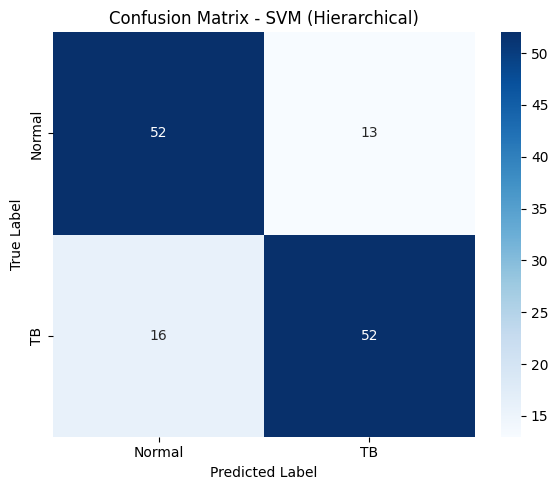


Evaluating: Naive Bayes (Hierarchical)
Stage 1 trained on 14 features (shape + basic stats)
Stage 2 trained on 46 features (all)

Accuracy: 0.7895

Classification Report:
              precision    recall  f1-score   support

      Normal       0.78      0.78      0.78        65
          TB       0.79      0.79      0.79        68

    accuracy                           0.79       133
   macro avg       0.79      0.79      0.79       133
weighted avg       0.79      0.79      0.79       133



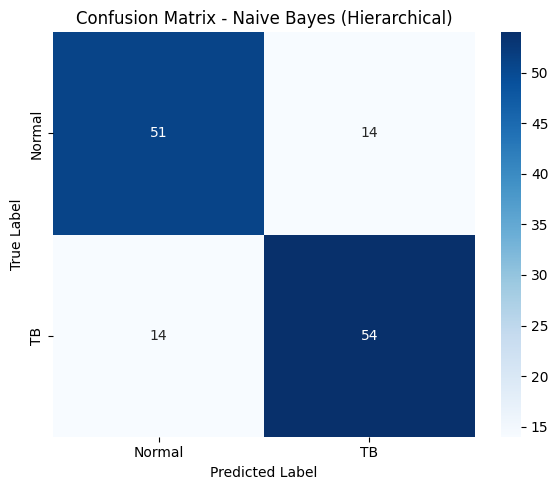


MODEL COMPARISON
      Model  Accuracy
        SVM  0.781955
Naive Bayes  0.789474


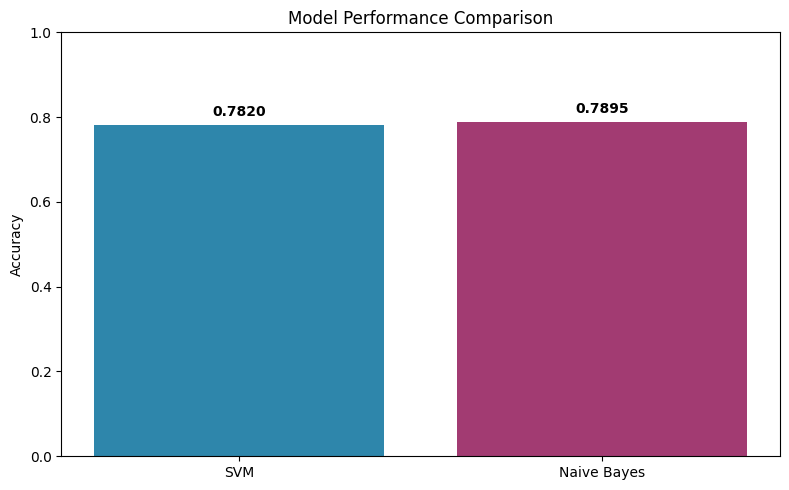


ANALYSIS COMPLETE!


In [40]:
def main():
    """
    Main execution function
    """
    print("="*60)
    print("TB DETECTION WITH HIERARCHICAL FEATURE EXTRACTION")
    print("="*60)

    # Initialize pipeline

    # Load data
    df = pd.DataFrame(data)
    # Shuffle the dataframe to ensure both classes are likely included when a limit is applied
    df = df.sample(frac=1, random_state=42).reset_index(drop=True)

    # Extract features
    print("\n" + "="*60)
    print("EXTRACTING FEATURES...")
    print("="*60)
    limit_cfg = CONFIG.get("limit_extract")
    if limit_cfg:
        print(f"Menggunakan limit ekstraksi fitur: {limit_cfg} gambar")
    features_df = extract_dataset(df, limit=limit_cfg)

    if len(features_df) < 2:
        print("\n⚠️ Minimal dibutuhkan 2 sampel untuk melakukan train/test split. Perbesar limit atau gunakan dataset lebih banyak.")
        return
    if features_df['label'].nunique() < 2:
        print("\n⚠️ Dataset hanya memiliki satu kelas. Tambahkan data untuk kedua kelas sebelum training.")
        return

    # Prepare data for training
    X = features_df.drop('label', axis=1)
    y = features_df['label']

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    print(f"\nTrain set: {len(X_train)} images")
    print(f"Test set: {len(X_test)} images")

    # Train and evaluate models
    print("\n" + "="*60)
    print("TRAINING AND EVALUATION")
    print("="*60)

    # SVM with Hierarchical Classification
    svm_model = klasifikasiHierarkis(model_type='svm')
    svm_acc, svm_pred = evaluate_model(svm_model, X_train, X_test,
                                       y_train, y_test,
                                       "SVM (Hierarchical)")

    # Naive Bayes with Hierarchical Classification
    nb_model = klasifikasiHierarkis(model_type='nb')
    nb_acc, nb_pred = evaluate_model(nb_model, X_train, X_test,
                                     y_train, y_test,
                                     "Naive Bayes (Hierarchical)")

    # Comparison
    print("\n" + "="*60)
    print("MODEL COMPARISON")
    print("="*60)
    comparison_df = pd.DataFrame({
        'Model': ['SVM', 'Naive Bayes'],
        'Accuracy': [svm_acc, nb_acc]
    })
    print(comparison_df.to_string(index=False))

    # Visualization
    plt.figure(figsize=(8, 5))
    plt.bar(comparison_df['Model'], comparison_df['Accuracy'],
            color=['#2E86AB', '#A23B72'])
    plt.ylabel('Accuracy')
    plt.title('Model Performance Comparison')
    plt.ylim([0, 1])
    for i, v in enumerate(comparison_df['Accuracy']):
        plt.text(i, v + 0.02, f'{v:.4f}', ha='center', fontweight='bold')
    plt.tight_layout()
    plt.show()

    print("\n" + "="*60)
    print("ANALYSIS COMPLETE!")
    print("="*60)

if __name__ == "__main__":
    main()

TB DETECTION WITH HIERARCHICAL FEATURE EXTRACTION

EXTRACTING FEATURES...
Processing image 1/662...
Processing image 51/662...
Processing image 51/662...
Processing image 101/662...
Processing image 101/662...
Processing image 151/662...
Processing image 151/662...
Processing image 201/662...
Processing image 201/662...
Processing image 251/662...
Processing image 251/662...
Processing image 301/662...
Processing image 301/662...
Processing image 351/662...
Processing image 351/662...
Processing image 401/662...
Processing image 401/662...
Processing image 451/662...
Processing image 451/662...
Processing image 501/662...
Processing image 501/662...
Processing image 551/662...
Processing image 551/662...
Processing image 601/662...
Processing image 601/662...
Processing image 651/662...
Processing image 651/662...

Feature extraction selesai!
Total fitur yang diekstrak: 46

Train set: 529 images
Test set: 133 images

TRAINING AND EVALUATION

Evaluating: SVM (Hierarchical)
Stage 1 train

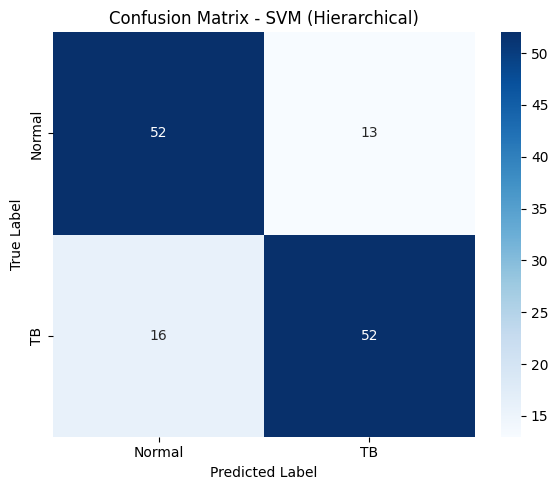


Evaluating: Naive Bayes (Hierarchical)
Stage 1 trained on 14 features (shape + basic stats)
Stage 2 trained on 46 features (all)

Accuracy: 0.7895

Classification Report:
              precision    recall  f1-score   support

      Normal       0.78      0.78      0.78        65
          TB       0.79      0.79      0.79        68

    accuracy                           0.79       133
   macro avg       0.79      0.79      0.79       133
weighted avg       0.79      0.79      0.79       133



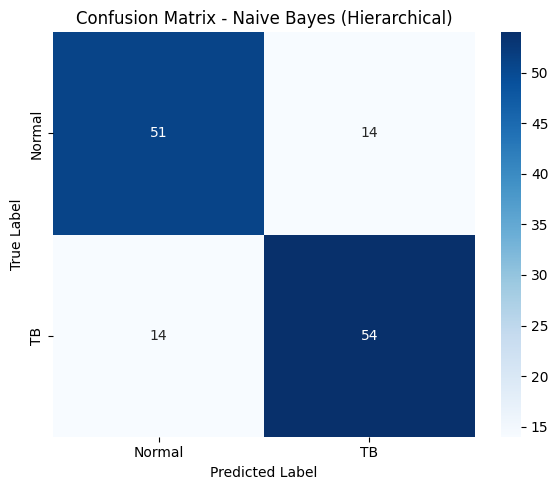

[INFO] Models saved → svm_dummy.pkl, nb_dummy.pkl

MODEL COMPARISON
      Model  Accuracy
        SVM  0.781955
Naive Bayes  0.789474


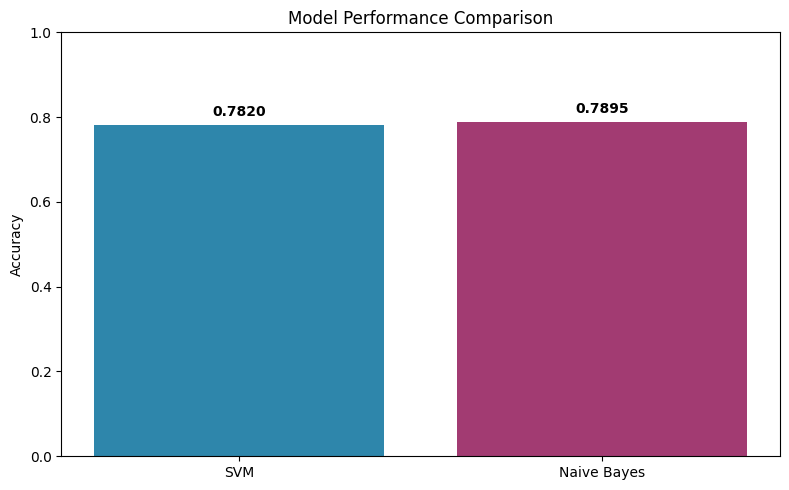


ANALYSIS COMPLETE!


In [41]:
def main():
    """
    Main execution function
    """
    print("="*60)
    print("TB DETECTION WITH HIERARCHICAL FEATURE EXTRACTION")
    print("="*60)

    # Initialize pipeline

    # Load data
    df = pd.DataFrame(data)
    # Shuffle the dataframe to ensure both classes are likely included when a limit is applied
    df = df.sample(frac=1, random_state=42).reset_index(drop=True)

    # Extract features
    print("\n" + "="*60)
    print("EXTRACTING FEATURES...")
    print("="*60)
    limit_cfg = CONFIG.get("limit_extract")
    if limit_cfg:
        print(f"Menggunakan limit ekstraksi fitur: {limit_cfg} gambar")
    features_df = extract_dataset(df, limit=limit_cfg)

    if len(features_df) < 2:
        print("\n⚠️ Minimal dibutuhkan 2 sampel untuk melakukan train/test split. Perbesar limit atau gunakan dataset lebih banyak.")
        return
    if features_df['label'].nunique() < 2:
        print("\n⚠️ Dataset hanya memiliki satu kelas. Tambahkan data untuk kedua kelas sebelum training.")
        return

    # Prepare data for training
    X = features_df.drop('label', axis=1)
    y = features_df['label']

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    print(f"\nTrain set: {len(X_train)} images")
    print(f"Test set: {len(X_test)} images")

    # Train and evaluate models
    print("\n" + "="*60)
    print("TRAINING AND EVALUATION")
    print("="*60)

    # SVM with Hierarchical Classification
    svm_model = klasifikasiHierarkis(model_type='svm')
    svm_acc, svm_pred = evaluate_model(svm_model, X_train, X_test,
                                       y_train, y_test,
                                       "SVM (Hierarchical)")

    # Naive Bayes with Hierarchical Classification
    nb_model = klasifikasiHierarkis(model_type='nb')
    nb_acc, nb_pred = evaluate_model(nb_model, X_train, X_test,
                                     y_train, y_test,
                                     "Naive Bayes (Hierarchical)")

    # Save Trained Models
    save_models(svm_model, nb_model)

    # Comparison
    print("\n" + "="*60)
    print("MODEL COMPARISON")
    print("="*60)
    comparison_df = pd.DataFrame({
        'Model': ['SVM', 'Naive Bayes'],
        'Accuracy': [svm_acc, nb_acc]
    })
    print(comparison_df.to_string(index=False))

    # Visualization
    plt.figure(figsize=(8, 5))
    plt.bar(comparison_df['Model'], comparison_df['Accuracy'],
            color=['#2E86AB', '#A23B72'])
    plt.ylabel('Accuracy')
    plt.title('Model Performance Comparison')
    plt.ylim([0, 1])
    for i, v in enumerate(comparison_df['Accuracy']):
        plt.text(i, v + 0.02, f'{v:.4f}', ha='center', fontweight='bold')
    plt.tight_layout()
    plt.show()

    print("\n" + "="*60)
    print("ANALYSIS COMPLETE!")
    print("="*60)

if __name__ == "__main__":
    main()

Memproses gambar: D:\Vscode\MicrosoftVSCode\PCD\Project\TBC_Testing.jpg
Model tersimpan tidak ditemukan. Jalankan dahulu sel training dan simpan model.
Model tersimpan tidak ditemukan. Jalankan dahulu sel training dan simpan model.


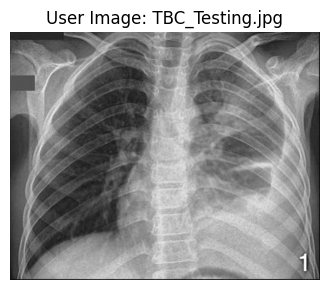

In [42]:
# ===== Inference gambar tunggal berdasarkan input user =====
user_image = CONFIG.get("user_image_path")
if not user_image:
    print("Tidak ada path gambar yang diberikan. Jalankan ulang sel konfigurasi dan isi path gambar untuk mencoba inference.")
else:
    user_image = Path(user_image)
    if not user_image.exists():
        print(f"Path gambar {user_image} tidak ditemukan.")
    else:
        print(f"Memproses gambar: {user_image}")
        features = process_single_image(str(user_image))
        if features is None:
            print("Gagal mengekstrak fitur dari gambar ini.")
        else:
            features_df = pd.DataFrame([features])
            try:
                svm_model, nb_model = load_models()
            except FileNotFoundError:
                print("Model tersimpan tidak ditemukan. Jalankan dahulu sel training dan simpan model.")
                svm_model = nb_model = None

            if svm_model and nb_model:
                svm_pred = svm_model.predict(features_df)[0]
                nb_pred = nb_model.predict(features_df)[0]
                label_map = {0: 'Normal', 1: 'TB'}
                print(f"Prediksi SVM : {label_map.get(svm_pred, svm_pred)}")
                print(f"Prediksi Naive Bayes : {label_map.get(nb_pred, nb_pred)}")

            # Tampilkan gambar input
            img = cv2.imread(str(user_image), cv2.IMREAD_GRAYSCALE)
            if img is not None:
                plt.figure(figsize=(4,4))
                plt.imshow(img, cmap='gray')
                plt.title(f"User Image: {user_image.name}")
                plt.axis('off')
                plt.show()
            else:
                print("OpenCV gagal membaca gambar untuk visualisasi.")